In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import pandas as pd
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import PIL
import re
import time
from kaggle_datasets import KaggleDatasets
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    #print("can't initialize tpu, using default, exception: " + str(e))
    strategy = tf.distribute.get_strategy()
#print('Number of replicas:', strategy.num_replicas_in_sync)

#AUTOTUNE = tf.data.experimental.AUTOTUNE

from PIL import Image
import shutil


D0731 02:12:28.466142448   25361 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0731 02:12:28.466169974   25361 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0731 02:12:28.466173303   25361 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0731 02:12:28.466176050   25361 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0731 02:12:28.466178318   25361 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0731 02:12:28.466180675   25361 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0731 02:12:28.466183025   25361 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0731 02:12:28.

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


/usr/local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:
# return the image from the TFRecord
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(sample):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    sample = tf.io.parse_single_example(sample, tfrecord_format)
    image = decode_image(sample['image'])
    return image


In [4]:
# define the function to extract the image from the files
def load_data(filenames, labeled=True, ordered=False):
    data = tf.data.TFRecordDataset(filenames)
    data = data.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return data

In [5]:
# load in the datasets
gcs_path = KaggleDatasets().get_gcs_path()
monet_file = tf.io.gfile.glob(str(gcs_path + '/monet_tfrec/*.tfrec'))
monet_ds = load_data(monet_file, labeled=True).batch(32)

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/gan-getting-started


In [6]:
# Create iterators
sample_monet = next(iter(monet_ds))

In [7]:
# view shape of the datasets
print(sample_monet.shape)

(32, 256, 256, 3)


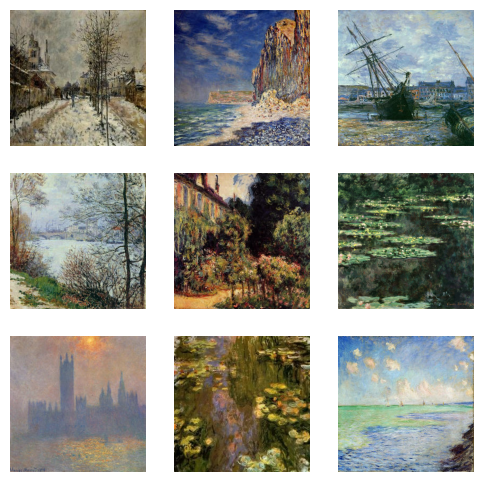

In [8]:

plt.figure(figsize = (6, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_monet[i] * 0.5 + 0.5)
    plt.axis("off")

In [9]:
# create a function to build the generator model
def create_generator():
    model = Sequential()

    n_nodes = 16 * 16 * 512 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_shape=(100,)))
    model.add(Reshape((16, 16, 512)))
   
    model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
        
    model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
        
    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
        
#     model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-5'))
#     model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(3, kernel_size=(3, 3), activation='tanh', strides=(2, 2), padding='same'))
  
    return model

In [10]:
# Use the noise vector to create an image. The generator is still untrained here!
with strategy.scope():
    generator = create_generator()


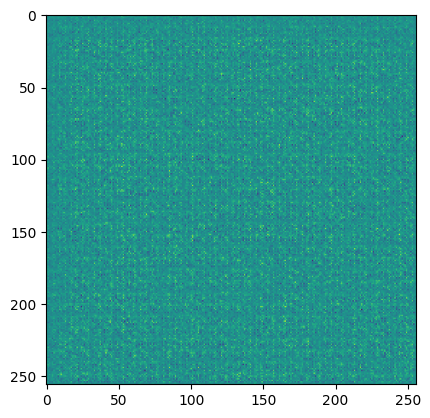

In [11]:

noise = tf.random.normal([1, 100])
with strategy.scope():
    generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [12]:

def create_discriminator():
    model = Sequential() # Model
    
#     model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
#     model.add(LeakyReLU(alpha=0.2))
    
#     model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.2))
       
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
      
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
  
    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten()) # Flatten the shape
    model.add(Dropout(0.3)) 
    model.add(Dense(1, activation='sigmoid')) # Output Layer
    
    return model


In [13]:

with strategy.scope():
    discriminator = create_discriminator()


In [14]:

with strategy.scope():
    decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50005335]], shape=(1, 1), dtype=float32)


In [15]:

with strategy.scope():
    def generator_loss(fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(real_output, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

In [16]:
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [18]:
EPOCHS = 140
BATCH_SIZE = 32
noise_dim = 100
shape_dim = [256,256,3]

In [19]:
class DCGAN_model:
    def __init__(self, noise_dim, EPOCHS, BATCH_SIZE, generator, discriminator, dataset):  
        self.noise_dim = noise_dim
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.generator = generator
        self.dataset = dataset
    
    @tf.function
    def train(self, images):

        noise = tf.random.normal([images.shape[0], noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = self.generator(noise, training=True)
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        return (gen_loss + disc_loss) * 0.5
    
    @tf.function
    def distributed_train(self, images):
        per_replica_losses = strategy.run(self.train, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    
    def generate_images(self):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim]) 
        predictions = self.generator.predict(noise)
        return predictions
        
    def generate_and_plot_images(self):      
        image = self.generate_images()
        gen_imgs = 0.5 * image + 0.5
        fig = plt.figure(figsize=(6, 6))
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
        plt.show()

    def train_loop(self):
        e_ls = []
       
        for epoch in range(self.EPOCHS):
            start = time.time()
            
            for image_batch in self.dataset:
                loss = self.distributed_train(image_batch)

            num_batches = 0
            if (epoch+1) % 20 == 0:                                  
                print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
                self.generate_and_plot_images()
                
                e_ls.append(epoch+1)
               

/usr/local/lib/python3.8/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 20 is 0.8402411937713623 sec
1/1 [==============================] - 2s 2s/step


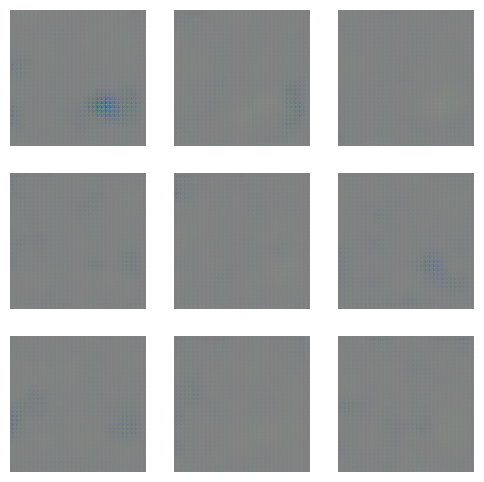

Time for epoch 40 is 0.8137550354003906 sec
1/1 [==============================] - 0s 463ms/step


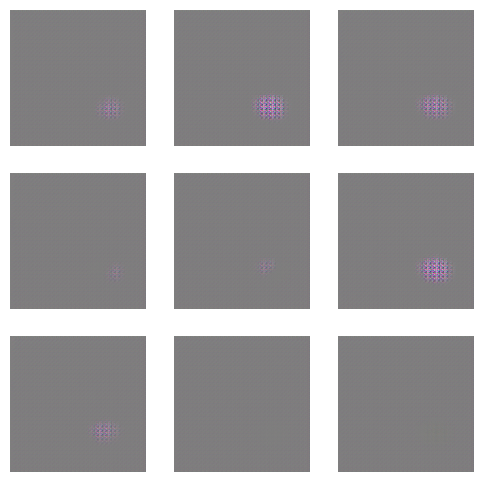

Time for epoch 60 is 0.8256785869598389 sec
1/1 [==============================] - 0s 413ms/step


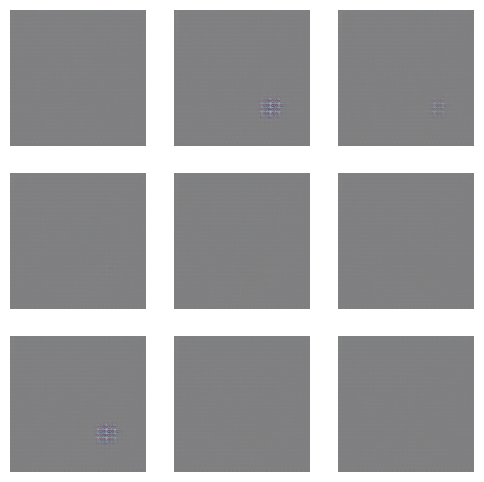

Time for epoch 80 is 0.8053386211395264 sec
1/1 [==============================] - 0s 449ms/step


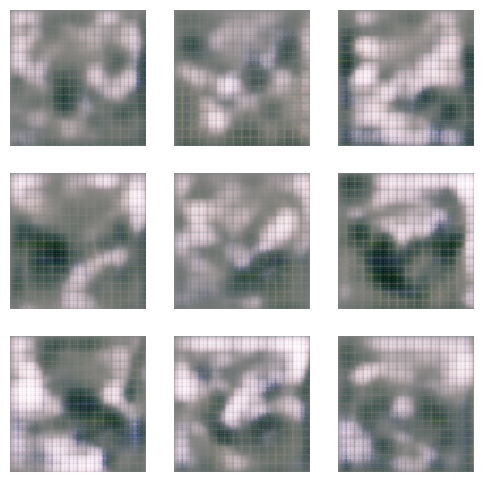

Time for epoch 100 is 0.8122329711914062 sec
1/1 [==============================] - 0s 458ms/step


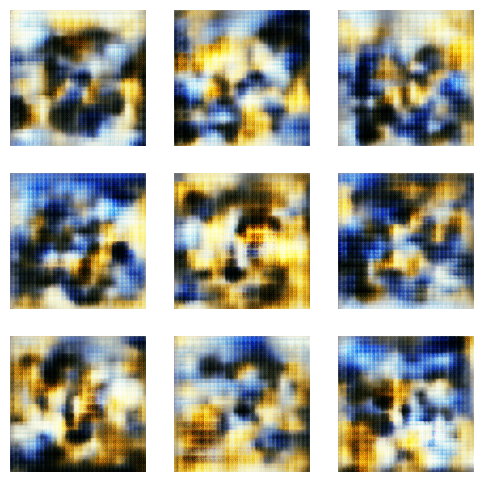

Time for epoch 120 is 0.8241407871246338 sec
1/1 [==============================] - 0s 439ms/step


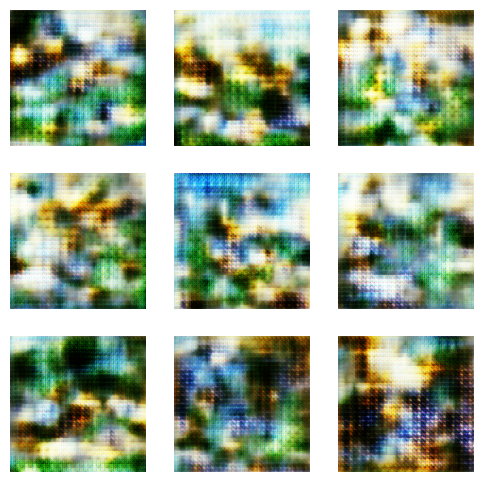

Time for epoch 140 is 0.8155105113983154 sec
1/1 [==============================] - 0s 405ms/step


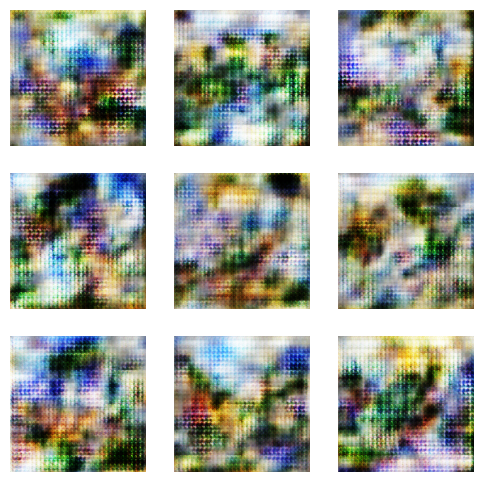

In [20]:
# train, visualize and print out the result for DCGAN model
gan1 = DCGAN_model(noise_dim, EPOCHS, BATCH_SIZE, generator, discriminator, monet_ds)
res1 = gan1.train_loop()
res1